In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyart
import dask.distributed as dsk
import matplotlib.image as mpimg
import numpy as np
from metpy.interpolate import cross_section


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Author: Andrew Brown

In [2]:
clnt = dsk.Client()

time
2022-03-01 10:30:00    35.545982
2022-03-01 11:30:00    35.195908
2022-03-06 12:30:00    34.883621
2022-03-01 09:30:00    34.796227
2022-03-06 11:30:00    34.738605
2022-03-06 10:30:00    34.518955
2022-03-06 13:30:00    34.132523
2022-03-01 08:30:00    33.895634
2022-03-06 14:30:00    33.223900
2022-02-28 03:30:00    32.955208
dtype: float32


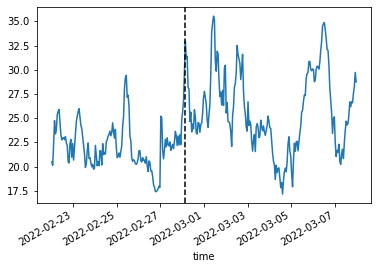

In [3]:
#First, load in 10 m wind gust data over SE Australia - identify spikes by looking at the domain maximum time series
#Although not the biggest spike, 2022-02-28 03:30 looks interesting (on inspecting the gust/radar structures)
#Note that a gust of 89 km/hr was measured in Swan Hill at around 04:30 UTC on the same day (and a dust storm in Mildura)

wg = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/wndgust_1hr_20220222_20220307.nc',
                    parallel=True, chunks = {'time': '200mb'}).\
                    sel({"latitude":slice(-45,-30),"longitude":slice(140,155)})
df=wg.max(("latitude","longitude")).wndgust.to_pandas()
print(df.sort_values(ascending=False).iloc[0:10])

ax=plt.axes()
df.plot(ax=ax)
ax.axvline("2022-02-28 03:30",color="k",ls="--");

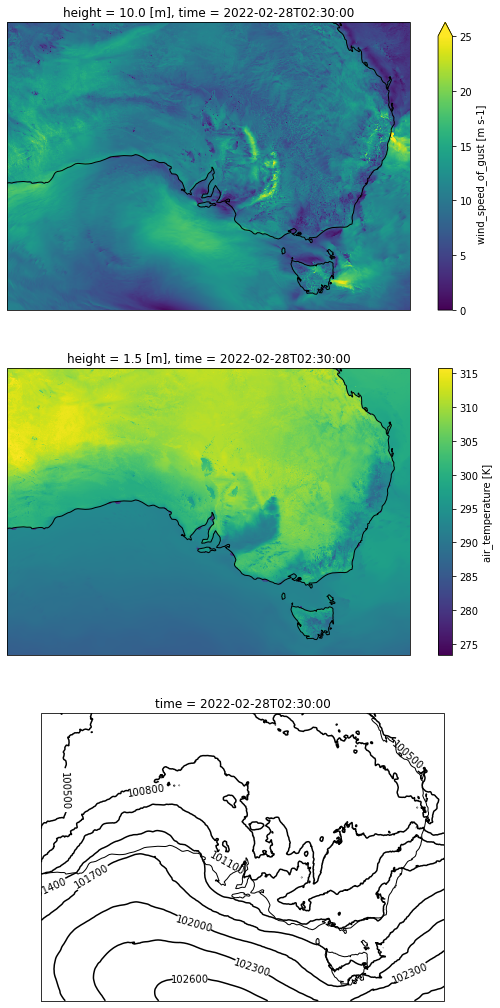

In [4]:
#Plot a few fields to get an idea of what's going on: a trough with widespread convection and well defined surface cold pool

wg = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/wndgust_1hr_20220222_20220307.nc',
                    parallel=True, chunks = {'time': '200mb'}).\
                    sel({"latitude":slice(-45,-20),"longitude":slice(120,155)})

tas = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/tas_1hr_20220222_20220307.nc',
                    parallel=True, chunks = {'time': '200mb'}).\
                    sel({"latitude":slice(-45,-20),"longitude":slice(120,155)})

psl = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/psl_1hr_20220222_20220307.nc',
                    parallel=True, chunks = {'time': '200mb'}).\
                    sel({"latitude":slice(-45,-20),"longitude":slice(120,155)})


plt.figure(figsize=[10,18])

ax=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
wg.sel({"time":"2022-02-28 02:30:00"}).wndgust.plot(vmin=0,vmax=25,ax=ax)
ax.coastlines()

ax=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
tas.sel({"time":"2022-02-28 02:30:00"}).tas.plot(ax=ax)
ax.coastlines()

ax=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
c=xr.plot.contour(psl.sel({"time":"2022-02-28 02:30:00"}).psl,ax=ax,levels=10,colors="k")
plt.clabel(c)
ax.coastlines()

In [5]:
#Load some more data to see what's going on over the convective region at around 2:00 UTC on 2022-02-28

# codes:
# - fld_s03i463_max: max gust
# - fld_s04i111: reflectivity
# - fld_s03i463: inst. gust

spec = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day7/history/atm/netCDF/umnsa_spec_20220228T0200_1h.nc',
                parallel=True, chunks = {'time': '200mb'}).\
                sel({"lat":slice(-36.5,-34),"lon":slice(141,144),"lat_0":slice(-36.5,-34),"lon_0":slice(141,144)})

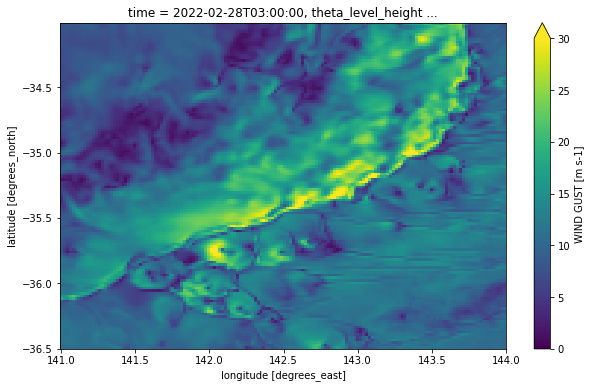

In [6]:
#Firstly, plot the 10-minute maximum wind gusts

plt.figure(figsize=[10,6])
spec.sel({"time":"2022-02-28 03:00:00"})["fld_s03i463"].plot(vmin=0,vmax=30)

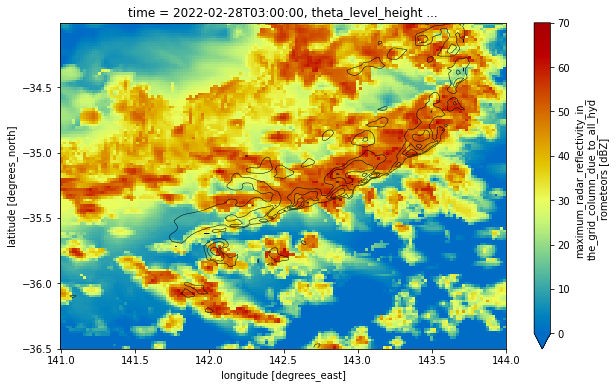

In [7]:
#Simulated column-maximum reflectivity (with + 25 m/s gusts contoured)

plt.figure(figsize=[10,6])
spec.sel({"time":"2022-02-28 03:00:00"})["fld_s04i111"].plot(cmap=plt.get_cmap("pyart_HomeyerRainbow"),vmin=0,vmax=70)
xr.plot.contour(spec.sel({"time":"2022-02-28 03:00:00"})["fld_s03i463"].squeeze(),levels=[20,25,30],colors="k",linewidths=0.5)

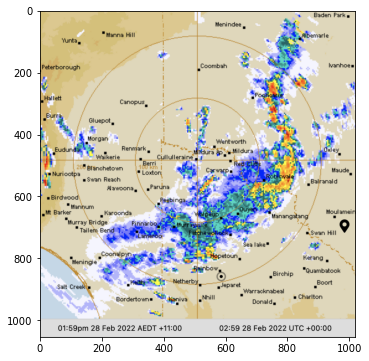

In [8]:
#Compare with an observed radar image

plt.figure(figsize=[10,6])
plt.imshow(mpimg.imread("/g/data/hh5/tmp/WACI-Hackathon-2023/share/ab4502/AUS2200_CLEX_analysis/notebooks/obs_refl.png",))

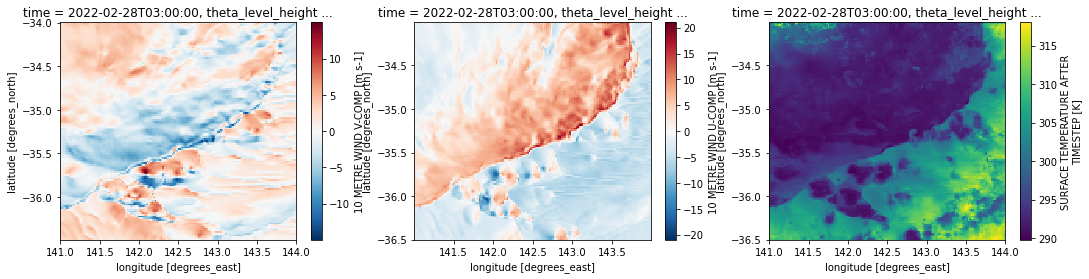

In [9]:
#U and V component of the wind, and surface temperature


plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
spec.sel({"time":"2022-02-28 03:00"})["fld_s03i210"].plot()

plt.subplot(1,3,2)
spec.sel({"time":"2022-02-28 03:00"})["fld_s03i209"].plot()

plt.subplot(1,3,3)
spec.sel({"time":"2022-02-28 03:00"})["fld_s00i024"].plot()


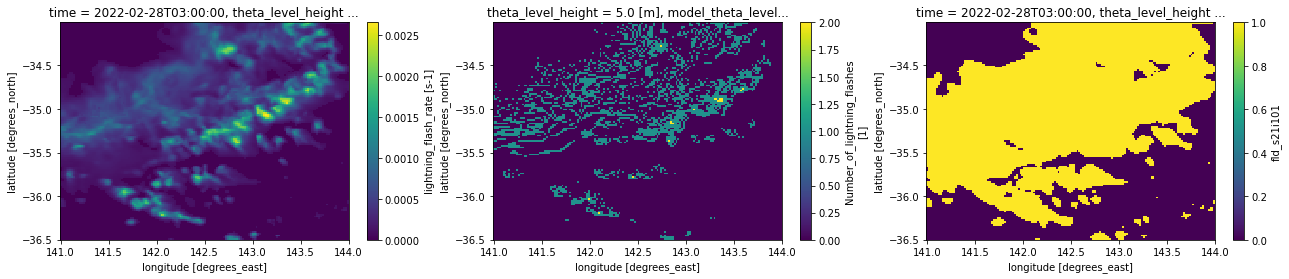

In [10]:
#Have a look at simulated lightning flash rate, number of lightning flashes, and "storm flag"

plt.figure(figsize=[22,4])

plt.subplot(1,3,1)
spec.sel({"time":"2022-02-28 03:00"})["fld_s21i100"].plot()

plt.subplot(1,3,2)
spec.interp({"time_0":"2022-02-28 02:55"},method="nearest")["fld_s21i104"].plot()

plt.subplot(1,3,3)
(spec.sel({"time":"2022-02-28 03:00"})["fld_s21i101"] * -1).plot()

In [11]:
#Now look at some model level data

mdl = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day7/history/atm/netCDF/umnsa_mdl_20220228T0200_1h.nc',
                parallel=True, chunks = {'time': '200mb'}).\
                sel({"lat":slice(-36.5,-34),"lon":slice(141,144),"lat_0":slice(-36.5,-34),"lon_0":slice(141,144)})

cld = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day7/history/atm/netCDF/umnsa_cldrad_20220228T0200_1h.nc',
                parallel=True, chunks = {'time': '200mb'}).\
                sel({"lat":slice(-36.5,-34),"lon":slice(141,144)})

Model level 16: ~1013.3332 m


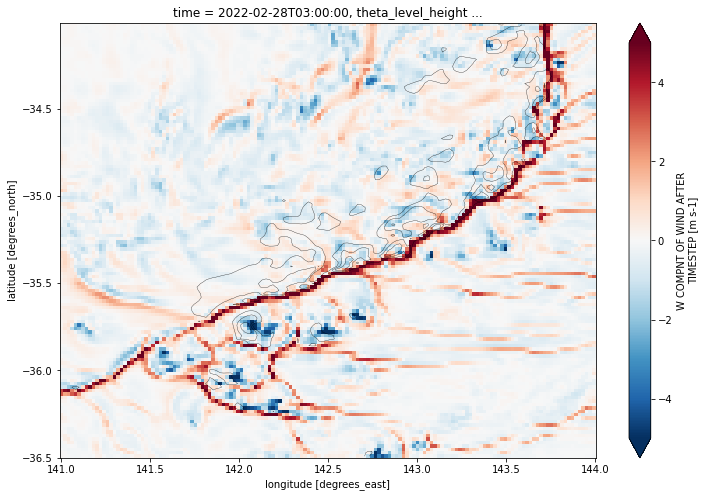

In [12]:
#Plot the vertical velocity at around 1000 m AGL. Contour + 20 m/s surface wind gusts. 

mdl_lvl=16
print("Model level "+str(mdl_lvl)+ ": ~"+str(mdl["rho_level_height"].values[mdl_lvl])+" m")

plt.figure(figsize=[12,8])
mdl.sel({"time":"2022-02-28 03:00","model_theta_level_number":mdl_lvl})["fld_s00i150"].plot(vmin=-5,vmax=5,cmap=plt.get_cmap("RdBu_r"))
xr.plot.contour(spec.sel({"time":"2022-02-28 03:00:00"})["fld_s03i463"].squeeze(),levels=[20,25,30],colors="k",linewidths=0.3)

Model level 16: ~1013.3332 m


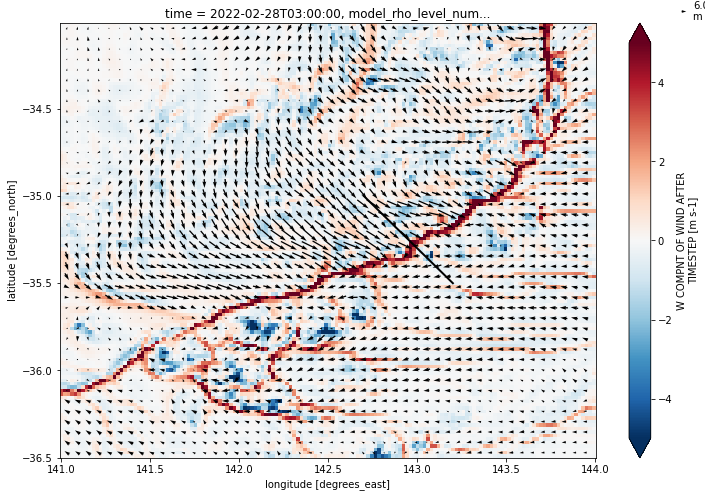

In [13]:
#Same plot, but with horizontal velocity at the same height. Also set up a transect for cross sections

mdl_lvl=16
print("Model level "+str(mdl_lvl)+ ": ~"+str(mdl["rho_level_height"].values[mdl_lvl])+" m")

u=mdl.sel({"time":"2022-02-28 03:00","model_rho_level_number":mdl_lvl})["fld_s00i002"]
v=mdl.sel({"time":"2022-02-28 03:00","model_rho_level_number":mdl_lvl})["fld_s00i003"].rename({"lat_0":"lat","lon_0":"lon"}).interp_like(u)


plt.figure(figsize=[12,8])
mdl.sel({"time":"2022-02-28 03:00","model_theta_level_number":mdl_lvl})["fld_s00i150"].plot(vmin=-5,vmax=5,cmap=plt.get_cmap("RdBu_r"))
xr.Dataset({"u":u.drop("sigma_rho"),"v":v.drop("sigma_rho")}).coarsen({"lat":3,"lon":3},boundary="trim").mean().plot.quiver(\
            x="lon",y="lat",u="u",v="v")

start = (-35,142.7)
end = (-35.5,143.2)
plt.plot([start[1],end[1]],[start[0],end[0]],color="k",lw=2)

In [14]:
#Calculate cross sections for the transect shown in previous plot

w_cross = cross_section(mdl.metpy.parse_cf()["fld_s00i150"].squeeze().rename({"lat":"latitude","lon_0":"longitude"}),start,end)
v_cross = cross_section(mdl.metpy.parse_cf()["fld_s00i003"].squeeze().rename({"lat_0":"latitude","lon_0":"longitude"}),start,end)
u_cross = cross_section(mdl.metpy.parse_cf()["fld_s00i002"].squeeze(),start,end)
refl_cross = cross_section(cld.metpy.parse_cf()["fld_s04i118"].squeeze(),start,end)
cld_liq_cross = cross_section(cld.metpy.parse_cf()["fld_s00i254"].squeeze(),start,end)
cld_ice_cross = cross_section(cld.metpy.parse_cf()["fld_s00i012"].squeeze(),start,end)
rain_cross = cross_section(cld.metpy.parse_cf()["fld_s00i272"].squeeze(),start,end)
graupel_cross = cross_section(cld.metpy.parse_cf()["fld_s00i273"].squeeze(),start,end)
ws_cross = np.sqrt(v_cross**2 + u_cross**2)

Text(0, 0.5, 'Height (m)')

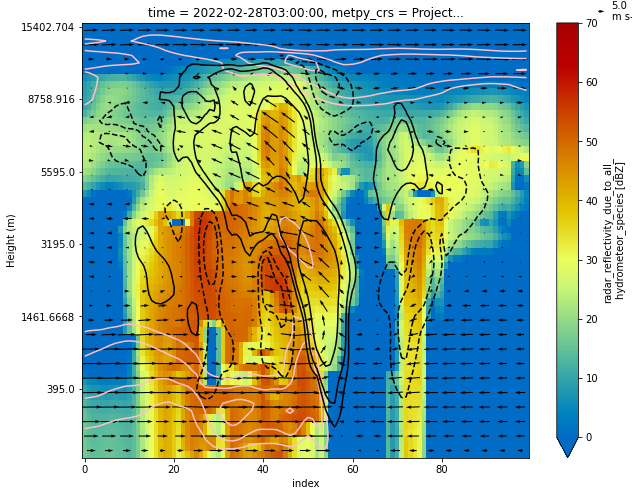

In [15]:
#Plot a cross section with:
# -> Reflectivity (shaded contours)
# -> Ground relative wind speed (pink contours)
# -> Ground relative U and W wind (vectors)
# -> W wind (black contours)

plt.figure(figsize=[10,8])
xr.plot.pcolormesh(refl_cross.sel({"model_theta_level_number":slice(1,60)}),cmap=plt.get_cmap("pyart_HomeyerRainbow"),vmin=0,vmax=70)
xr.plot.contour(ws_cross.sel({"model_rho_level_number":slice(1,60)}),colors="pink",levels=[15,20,25])
xr.plot.contour(w_cross.sel({"model_theta_level_number":slice(1,60)}),colors="k",levels=[-5,-2,-1,1,2,5])


xr.Dataset({"w":w_cross,"u":u_cross.rename({"model_rho_level_number":"model_theta_level_number"})}).sel({"model_theta_level_number":slice(1,60)}).\
                    coarsen({"model_theta_level_number":2,"index":4},boundary="trim").mean().\
                    plot.quiver(\
                    x="index",y="model_theta_level_number",u="u",v="w")

ticks = np.arange(10,70,10)
hgt = mdl["theta_level_height"].sel({"model_theta_level_number":ticks}).values
plt.yticks(ticks,hgt)
plt.ylabel("Height (m)")